# Lesson: wind flow, 4D data, numerical integrals

With this lesson, we are going to learn how to display wind field data (as vectors and as streamlines). We are also going to add a fourth dimension to our data cubes (the vertical dimension). Last but not least, we are going to learn that computing numerical derivatives and integrals in python is not that complicated, after all.

In [1]:
# Import the tools we are going to need today:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

## Data sources 

We are going to use the `ERA5_LowRes_MonthlyAvg_uvslp.nc` and `ERA5_LowRes_MonthlyAvg_4D_zuvw.nc` files that you can download from:
- [ERA5_LowRes_MonthlyAvg_uvslp.nc](https://cluster.klima.uni-bremen.de/~fmaussion/teaching/climate/ERA5_LowRes_MonthlyAvg_uvslp.nc)
- [ERA5_LowRes_MonthlyAvg_4D_zuvw.nc](https://cluster.klima.uni-bremen.de/~fmaussion/teaching/climate/ERA5_LowRes_MonthlyAvg_4D_zuvw.nc)

## Read the data

In [2]:
ds = xr.open_dataset('../data/ERA5_LowRes_MonthlyAvg_uvslp.nc')

**E: explore the file. Time coordinates? Variables? Units?**

In [3]:
# your answer here

## A glimpse in the internals of xarray 

Let's select a month out of our data and print our variable:

In [4]:
u = ds.u10.sel(month=1)
u

<xarray.DataArray 'u10' (latitude: 241, longitude: 480)>
[115680 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.6 -178.9 -178.1 ... 178.1 178.9 179.6
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
    month      int64 1
Attributes:
    units:      m s**-1
    long_name:  10 metre U wind component

On the second line, you should see something similar to:

    [115680 values with dtype=float32]
    
As we are going to see, this is a "trick" that xarray uses to hide an important information from us: xarray didn't actually *read* the data! However, as we have seen, xarray is very capable to plot this data or do mathematical operations on them. 

So why didn't xarray read the data yet? 

Because it assumes that we don't need it right away. This feature is called [lazy evaluation](https://en.wikipedia.org/wiki/Lazy_evaluation) in computer sciences. It is extremely useful, as it spares time and memory by loading the data only when really needed.

In some cases this feature can be undesirable. For example: when reading the data is quite slow. If you are working with data on remote directories, or if the data you are using is compressed (this is not the case here, but some files do). Reading remote or compressed data takes time, and the operations we are going to make below make this even slower.

This is why I'll sometimes recommend to do the following:

In [5]:
u = ds.u10.sel(month=1).load()
u

<xarray.DataArray 'u10' (latitude: 241, longitude: 480)>
array([[-0.05015272, -0.05015272, -0.05015272, ..., -0.05015272,
        -0.05015272, -0.05015272],
       [ 1.7704067 ,  1.7811189 ,  1.791321  , ...,  1.7250075 ,
         1.7392905 ,  1.7535734 ],
       [ 1.7280681 ,  1.7382703 ,  1.7500026 , ...,  1.6938913 ,
         1.7066438 ,  1.717356  ],
       ...,
       [-0.997415  , -1.0096575 , -1.0208797 , ..., -0.94436425,
        -0.9688492 , -0.9836422 ],
       [ 1.6357393 ,  1.6132948 ,  1.5934007 , ...,  1.6816487 ,
         1.677568  ,  1.6699164 ],
       [ 0.36813217,  0.36813217,  0.36813217, ...,  0.36813217,
         0.36813217,  0.36813217]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.6 -178.9 -178.1 ... 178.1 178.9 179.6
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
    month      int64 1
Attributes:
    units:      m s**-1
    long_name:  10 metre U wind component

**Q: compare the printed information with the one we've seen above. What has changed?**

Maybe it is a good moment to remind you that there are tools here to help you understand what certain commands do:

In [6]:
ds.u10.load?

Signature: ds.u10.load(**kwargs) -> 'T_DataArray'
Docstring:
Manually trigger loading of this array's data from disk or a
remote source into memory and return this array.

Normally, it should not be necessary to call this method in user code,
because all xarray functions should either work on deferred data or
load data automatically. However, this method can be necessary when
working with many file objects on disk.

Parameters
----------
**kwargs : dict
    Additional keyword arguments passed on to ``dask.compute``.

See Also
--------
dask.compute
File:      ~/disk/Dropbox/HomeDocs/git/xarray/xarray/core/dataarray.py
Type:      method


## Plotting wind fields

We are now reading the u and v windfields at the 10 m level for the month of January:

In [7]:
u = ds.u10.sel(month=1).load()
v = ds.v10.sel(month=1).load()

### Quiver plots

One traditional way to plot the wind data is as vector arrows. We can use a function called [quiver()](http://matplotlib.org/api/pyplot_api.html?highlight=quiver#matplotlib.pyplot.quiver) for that:

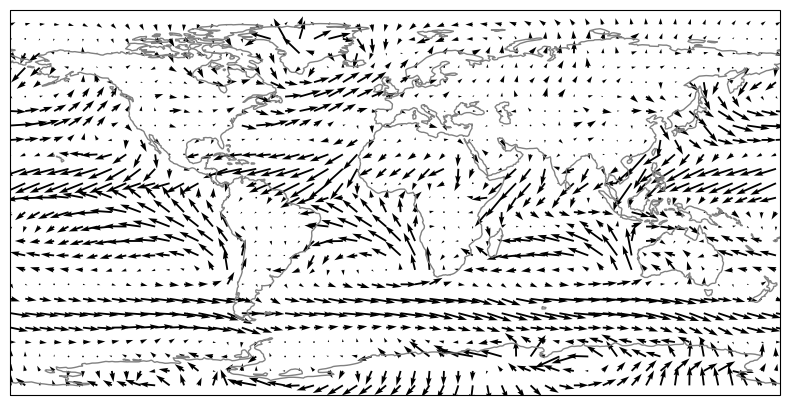

In [8]:
ax = plt.axes(projection=ccrs.PlateCarree())  # note that I changed the map projection
pu, pv = u[::9,::9], v[::9,::9]  # we will discuss what this line does in the cells below
qv = ax.quiver(pu.longitude, pu.latitude, pu, pv, transform=ccrs.PlateCarree())
ax.coastlines(color='grey');

Note the new syntax in the line ``pu, pv = u[::9,::9], v[::9,::9]``. Let's explain it in detail. the ``::9`` is the Numpy way to index each 9th element of an array. It is called [slicing](https://numpy.org/doc/stable/reference/arrays.indexing.html?highlight=basic%20slicing%20indexing#basic-slicing-and-indexing) in the numpy jargon. Let's try slicing on a simpler array:

In [9]:
a = np.arange(11)
print(a)

[ 0  1  2  3  4  5  6  7  8  9 10]


**E: try and explain the following commands:**
- a[:]
- a[2:]
- a[:-1]
- a[2:5]
- a[::-1]
- a[::2]
- a[::-2]

In [10]:
# your answer here

OK, so that was slicing in one dimension. Slicing also works in N-dimensions. For example:

In [14]:
a = np.arange(4*5).reshape((4, 5))
print(a)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]


**E: try and explain the following commands:**
- a[:, ::-1]
- a[::2, ::2]
- a[::2, ::3]

In [15]:
# your answer here

OK, that was slicing in two dimensions, so we now better understand what ``u[::9,::9]`` means. But what was about that comma in between? This is simply what people call "syntactic sugar", a nice and easy way to write one line in two: 

In [16]:
a, b = 12, 'Hello'
print(a)
print(b)

12
Hello


This kind of shortcuts should be used only if:
- the lines of code are easy
- the two variables are somehow related (for example u and v winds)

If you abuse this kind of "one-liners", people reading your code will hate you. 

**E: reproduce the quiver plot but with other slices. For example 5 or 15. What happens if you do no slicing at all?**

In [17]:
# your answer here

**E: compute the wind speed out of u and v. Plot the wind speed as a shaded color plot (as we did for temperature and precipitation) and plot the wind arrows on top of it.**

In [18]:
# your answer here

### Streamlines 

Another way to plot wind data are the so called [streamlines](http://matplotlib.org/api/pyplot_api.html?highlight=streamplot#matplotlib.pyplot.streamplot):

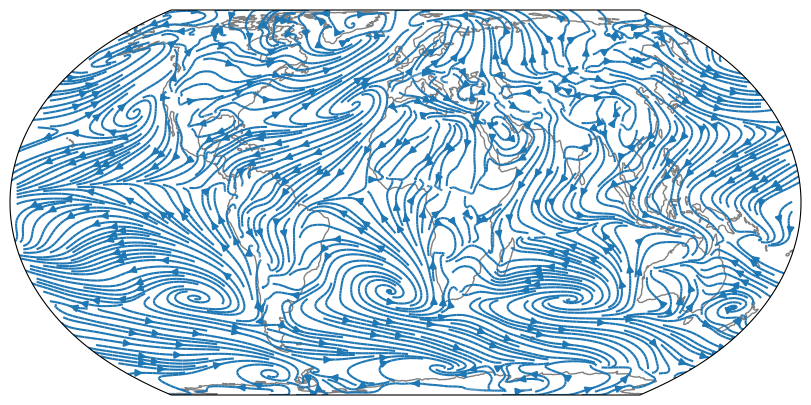

In [19]:
ax = plt.axes(projection=ccrs.EqualEarth())
ax.streamplot(u.longitude, u.latitude, u.values, v.values, transform=ccrs.PlateCarree(), density=4)
ax.coastlines(color='grey');

*Note: if this is too slow for your taste, you can slice your data like we did for the quiver plot, this will produce the plot faster*

A problem with streamlines is that they provide no information about the strength of the flow. It is possible to display this information with colors: 

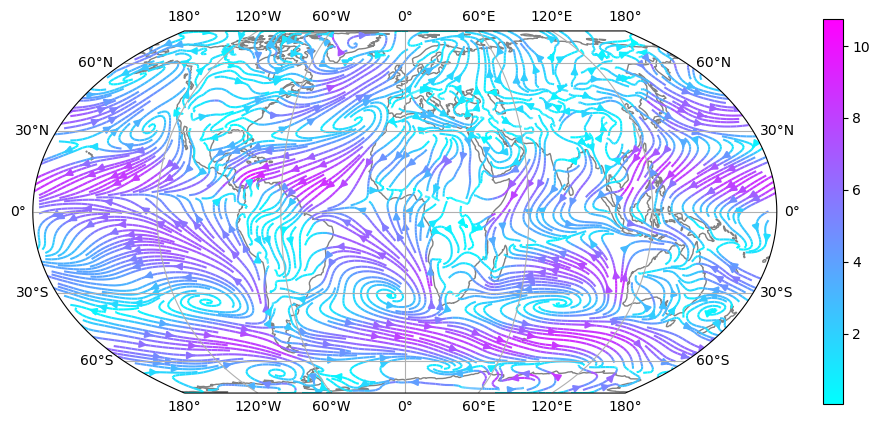

In [20]:
ws = (u**2 + v**2)**0.5
ax = plt.axes(projection=ccrs.EqualEarth())
strm = ax.streamplot(u.longitude, u.latitude, u.values, v.values, transform=ccrs.PlateCarree(),
                     density=4, color=ws.values, cmap=plt.get_cmap('cool'))
plt.colorbar(strm.lines)
ax.coastlines(color='grey'); ax.gridlines(draw_labels=True);  # what is this line doing?

**E: plot the wind streamlines for the month of july. Discuss the differences in the flow. Where it the ITCZ located for both months? Are there other large differences?**

In [21]:
# your answer here

## Upper atmosphere data  

We are now going to use the `ERA-Int-MonthlyAvg-4D-UVWZ.nc` file:

In [22]:
ds = xr.open_dataset('../data/ERA5_LowRes_MonthlyAvg_4D_zuvw.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 241, level: 16, longitude: 480, month: 12)
Coordinates:
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * level      (level) int32 10 50 100 200 300 400 ... 750 800 850 900 950 1000
  * longitude  (longitude) float32 -179.6 -178.9 -178.1 ... 178.1 178.9 179.6
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    z          (month, level, latitude, longitude) float32 ...
    u          (month, level, latitude, longitude) float32 ...
    v          (month, level, latitude, longitude) float32 ...
    w          (month, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-24 21:05:33 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [23]:
ds.level

<xarray.DataArray 'level' (level: 16)>
array([  10,   50,  100,  200,  300,  400,  500,  600,  650,  700,  750,  800,
        850,  900,  950, 1000], dtype=int32)
Coordinates:
  * level    (level) int32 10 50 100 200 300 400 ... 750 800 850 900 950 1000
Attributes:
    units:      millibars
    long_name:  pressure_level

**E: explore the file. Time coordinates? Variables? Units?**

We are going to analyse the data for the upper troposphere atmospheric circulation in exercise 08. In today's lesson, we are just going to note that it can be really easy to make zonal plots of the vertical structure of the atmopshere:

In [24]:
u_allz = ds.u.sel(month=1).load()
u_allz = u_allz.mean(dim='longitude')

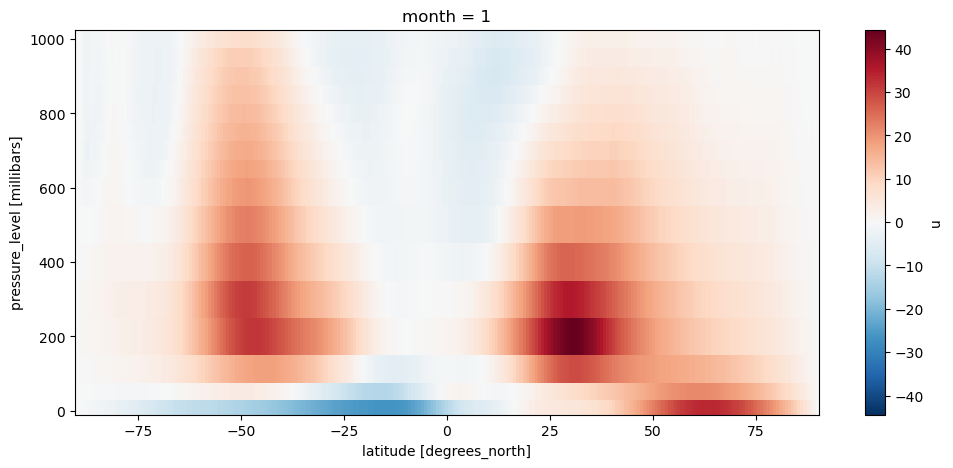

In [25]:
u_allz.plot();

Ugh. This is not so easy as we thought. Here's how to make it a bit better:

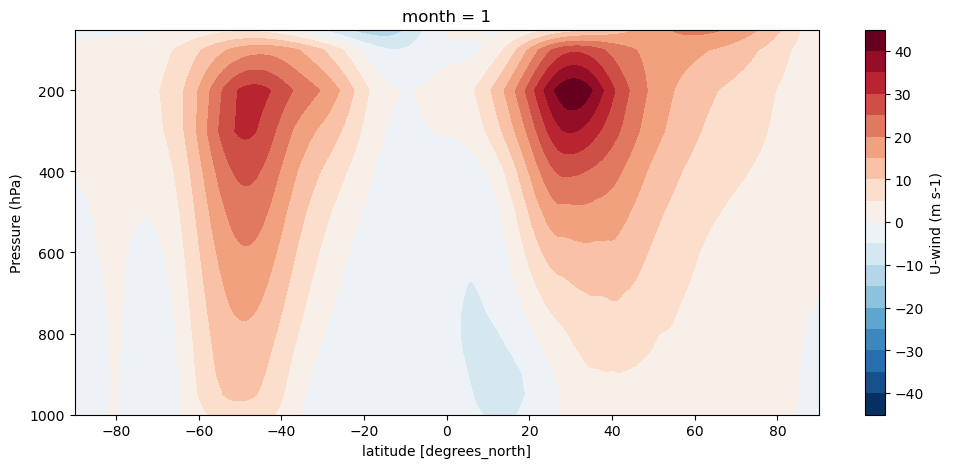

In [26]:
u_allz.plot.contourf(levels=np.linspace(-45, 45, 19), cbar_kwargs={'label':'U-wind (m s-1)'});
plt.ylim([1000, 50]);
plt.ylabel('Pressure (hPa)');

This representation of the atmosphere (with linear pressure coordinates) is often used and looks familiar. However, to represent more acurately the real altitude of the winds, a logarithmic scale might be better:

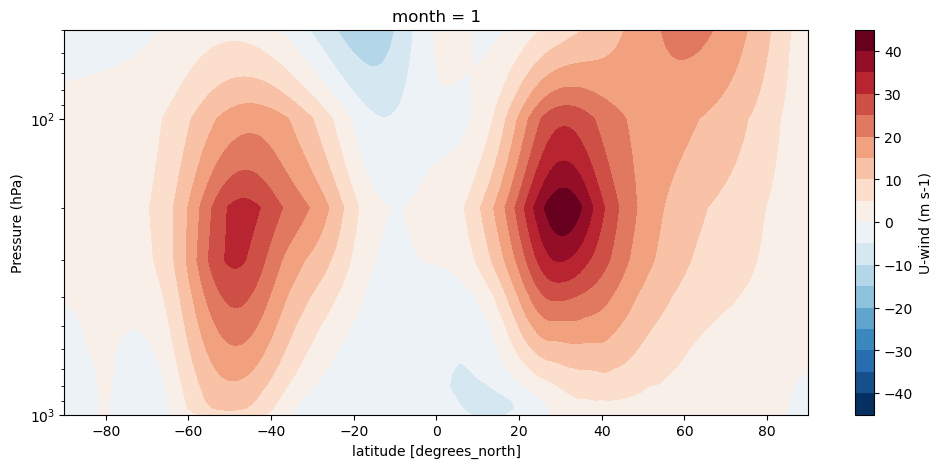

In [27]:
u_allz.plot.contourf(levels=np.linspace(-45, 45, 19), cbar_kwargs={'label':'U-wind (m s-1)'});
# u_allz.plot();
plt.ylim([1000, 50])
plt.yscale('log')
plt.ylabel('Pressure (hPa)');

With a logarithmic scale the importance of the westerly winds for most parts of the atmosphere is clearly visible.

## Numerical derivatives of gridded data: geostrophic winds

In this lesson we are going to learn how to compute the derivative of a meteorological field. One of the easiest formulas available to us is the geostrophic wind equation. We will compute geostrophic winds out of the geopotential field.

The geostrophic equation can be expressed in pressure coordinates as:

$$u_g = -\frac{g}{f} \frac{\partial z}{\partial y}$$

$$v_g = \frac{g}{f} \frac{\partial z}{\partial x}$$

with $u_g$, $v_g$ the geostrophic wind components and z the geopotential (in m).


First we need to compute the corolis parameter $f = 2  \Omega \sin \varphi$:

In [28]:
f = 2. * 7.292115e-5 * np.sin(np.deg2rad(u.latitude))

To avoid some mathematical singularities we are going to mask out the areas of the globe where coriolis becomes too close to zero: 

In [29]:
f = f.where((np.abs(u.latitude) > 5) & (np.abs(u.latitude) < 85))

### Gradient of a 2d field

Computing the [gradient of discrete data](https://en.wikipedia.org/wiki/Finite_difference_method) is something computers know how to do. For the details of the algorithm you can refer to other courses in numerical methods. Here we are going to use the function [gradient()](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html) provided by numpy:

In [30]:
g = 9.81
z = ds.z.sel(month=1, level=500).load() / g

In [31]:
grad_y, grad_x = np.gradient(z, -np.deg2rad(.75), np.deg2rad(.75))

**E: What is z? Plot it on a map.**

In [32]:
# your answer here

**Q: read the documentation of the np.gradient function. Explain why I needed to provide -np.deg2rad(.75) and np.deg2rad(.75) as arguments. What is the shape of grad_y and grad_x? Why are they returned by the function in that order?**

Because np.gradient() is not giving us `xr.DataArray` variables back. We are going to convert them back to xarray objects: 

In [33]:
grad_x = z * 0 + grad_x
grad_y = z * 0 + grad_y
grad_x.name = 'Gradient of z along x'
grad_y.name = 'Gradient of z along y'

There are other ways to do what we just did above, but this is easy to remember.

**Q: Now plot the variables grad_x and grad_y**

In [34]:
# Your answer here

Before moving foreward I have to draw your attention towards a certain detail. The equations of geostrophic winds described above are provided in *cartesian* (x, y) coordinates. We just computed the gradient in *spherical* (lon, lat) coordinates. Once again, we have to remember that the Earth is not flat and take this effect into account:

$$\frac{\partial}{\partial x} = \frac{1}{R \cos \varphi}\frac{\partial}{\partial\lambda}$$

$$\frac{\partial}{\partial y} = \frac{1}{R}\frac{\partial}{\partial\varphi}$$

with $\lambda$, $\varphi$ the longitude and latitude and R the Earth' radius. We apply the formulas and define a factor for the spherical derivatives:

In [35]:
dx = 1 / (6371000 * np.cos(np.deg2rad(z.latitude)))
dy = 1 / (6371000)

In [36]:
ug = - g / f * dy * grad_y
vg = g / f * dx * grad_x

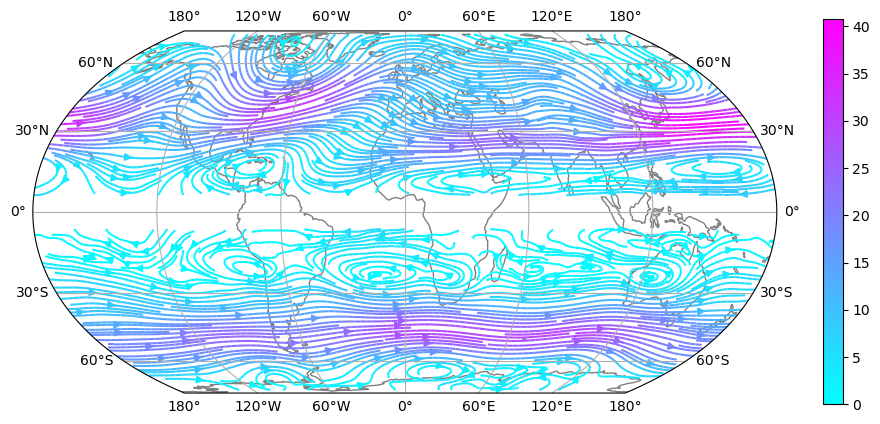

In [37]:
wsg = (ug**2 + vg**2)**0.5
ax = plt.axes(projection=ccrs.EqualEarth())
strm = ax.streamplot(ug.longitude, ug.latitude, ug.values, vg.values, transform=ccrs.PlateCarree(),
                     density=4, color=wsg.values, cmap=plt.get_cmap('cool'))
plt.colorbar(strm.lines)
ax.coastlines(color='grey'); ax.gridlines(draw_labels=True);

## Numerical integrals of gridded data: stream functions

### Vertical velocity

**E: compute the annual average of the vertical component of the wind. Plot the 500 hPa level on a map.**

**Q: discuss the features of the plot. Order of magnitude of w in comparison to u and v? Where are the largest velocities? Look at the sign of w in the tropics and the subtropics. Does it make sense?**

In [38]:
# your answer here

**E: multiply w by -1 to make positive velocities point upwards. Plot the 850 hPa level on a map with the vmin=-0.2 and vmax=0.2 keywords. Some features are expected such as the ITCZ, but some are strange. What can you say about the w field in general?**

In [39]:
# your answer here

### Zonal averages of the meridional and vertical wind components

Let's compute the temporal-zonal averages of the meridional and vertical components of the wind $\left[ \overline{v} \right]$ and  $\left[ \overline{w} \right]$:

In [40]:
v = ds.v.mean(dim=['month', 'longitude'])
w = - ds.w.mean(dim=['month', 'longitude'])

**E: make a countour plot (.plot.contourf()) of v and w. Be sure that the vertical levels showing upwards (plt.ylim([1000, 50])). Select the levels appropriatly, for example np.linspace(-2, 2, 21) for v and np.linspace(-0.1, 0.1, 21) for w.**

**Q: discuss the plots. Do they correspond to your expectations from the lecture?**

In [41]:
# your answer here

Note that u and w are the components of a wind vector in the meridional plane. As such they could be represented by arrows:

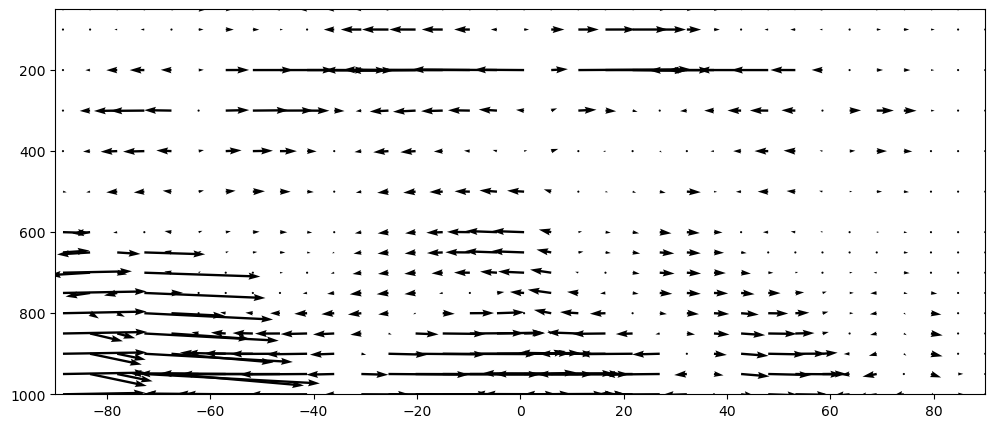

In [42]:
pv, pw = v[:, ::7], w[:, ::7]
qv = plt.quiver(pv.latitude, pv.level, pv.values, pw.values)
plt.ylim([1000, 50]);
plt.xlim([-90, 90]);

**Q: discuss the quiver plot above. Is it easy to interpret? For which reason?**

**E: define a new variable w_mult wich is w multiplied by 20. Make the quiver plot again. Better?**

In [43]:
# your answer here

### Stream function and Hadley circulation

In the meridional plane (since we have averaged over all longitudes), the continuity equation reduces to:
    
$$ \nabla \cdot \left[\mathbf{u} \right] = \frac{\partial \left[ \overline{v} \right]}{\partial y} + \frac{\partial \left[ \overline{w} \right]}{\partial p} = 0 $$

Where the brackets denote the zonal average. In spherical pressure coordinates, the same continuity equation writes:

$$ \frac{1}{R \cos \varphi} \frac{\partial \left( \left[ \overline{v} \right] \cos \varphi \right)}{\partial \varphi} + \frac{\partial \left[ \overline{w} \right]}{\partial p} = 0 $$

This equation is very useful since any convergence in the horizontal meridional flow must be balanced by divergence in the vertical flow. In other words: only one variable ($ \left[ \overline{v} \right]$ or $ \left[ \overline{w} \right]$) is needed to define the flow in the plane. With a little bit of mathematical manipulation, a [stream function](https://en.wikipedia.org/wiki/Stream_function) can be used for this purpose.

Let's define the funtion $\Psi$ such that the continuity equation above is satisfied:

$$ \left[ \overline{v} \right] = \frac{g}{2 \pi R \cos \varphi} \frac{\partial \Psi}{\partial p}$$

and

$$ \left[ \overline{w} \right] = - \frac{g}{2 \pi R^2 \cos \varphi} \frac{\partial \Psi}{\partial \varphi}$$

(the normalisation by $g / 2 \pi $ is convention, but the relative minus sign is required. $g$ is added so that $\Psi$ is of unit kg s$^{-1}$, a mass flux).

So $\Psi$ could be defined from either $w$ or $v$. Since $w$ in the atmosphere is very small, noisy, and subject to observational errors we will use $ \left[ \overline{v} \right]$ to compute it. Integrating the equation above from the tropopause (where $\Psi$ is assumed to be zero) *down* to some level $p$ gives:

$$ \Psi (\varphi, p) = \frac{2 \pi R \cos \varphi}{g} \int_{p_{trop}}^{p} \left[ \overline{v(\varphi, p)} \right] dp $$

The integral above can be computed numerically from our $\left[ \overline{v} \right]$ field. $\Psi (\varphi, p) $ is a mass transport (kg s$^{-1}$) equal to the rate at which mass is transported meridionally in the region between the level $p$ and the tropopause by the zonal mean circulation.

### Back to python: numerical integration

How to integrate the geophysical field $\left[\overline{v} \right]$? Like derivation, numerical integration is a thing that computers know how to do. Here again we are going to use a [function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.cumulative_trapezoid.html) for it. You'll learn in more detail how the numerical integration works in the numerics course. The purpose of our exercises is to "demystify" a litte bit these operations which can be quite simple to use in python.

**Q: read the documentation of the function cumulative_trapezoid().** Interested students can read about the trapezoidal rule in [wikipedia](https://en.wikipedia.org/wiki/Trapezoidal_rule) for example.

In [1]:
from scipy.integrate import cumulative_trapezoid

In [2]:
zcoords = v.level * 100  # note the "* 100" to convert hPa into SI units!
integral = cumulative_trapezoid(v, zcoords, axis=0, initial=0)  # are we clear on what this function does?
psi = v * 0 + integral  # store the data in a new xarray DataArray

NameError: name 'v' is not defined

This above might be a bit complicated to understand. Don't hesitate to ask me for more details!

Finally, we need to compute the factor $ \frac{2 \pi R \cos \varphi}{g} $ and multiply it to our integral:

In [46]:
fac = 2 * np.pi * 6371000 * np.cos(np.deg2rad(v.latitude)) / 9.81
psi = psi * fac
# Convert to Sverdrups:
psi = psi / 1e9

All done! Let's plot the result:

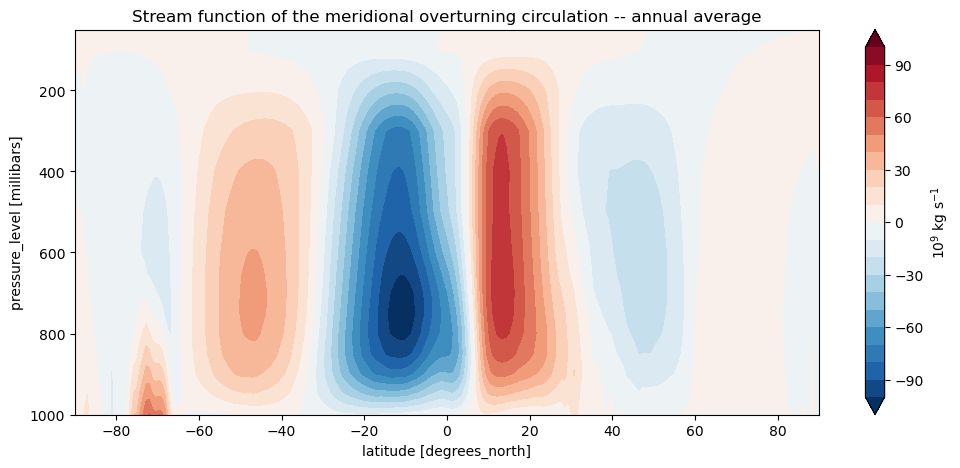

In [47]:
psi.plot.contourf(levels=np.linspace(-100, 100, 21), extend='both', cbar_kwargs={'label':'10$^9$ kg s$^{-1}$'})
plt.title('Stream function of the meridional overturning circulation -- annual average')
plt.ylim([1000, 50]);

Remember that the stream function plotted above is a function representation for a 2D flow. The w component of the wind is propotional to $- \frac{\partial \Psi}{\partial \varphi}$, the v component is propotional to $\frac{\partial \Psi}{\partial p}$

**Q: describe the meridional overturning circulation represented above. Name the cells you recognize and describe their circulation. Compare the circulation as described by $\Psi$ to the v and w plots you made in section "Zonal averages of the meridional and vertical wind components" above.**

## What's next? 

You can go directly to this week's [assignment](02_Assignment_GeneralCirculation)!